# Prepare the AnnData object

Clean up the `.obs` and `.var` annotations a bit, adjust the cell-type annotations and their colors, add information about transcription factors etc. The data we use here comes from [Packer et al., Science 2019](https://www.science.org/doi/10.1126/science.aax1971) and is available via [figshare](https://doi.org/10.6084/m9.figshare.c.6533377.v1). 

Changelog
- Compute and save UMAP embedding in here. 

## Preliminaries

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import scvelo as scv
import anndata as ad
import moscot as mc
import moslin_utils as mu
from moslin_utils.constants import FIG_DIR, DATA_DIR, TIME_KEY, TIMEPOINTS
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import spatial_utils as su

import numpy as np
import scipy.sparse as sp
import pandas as pd

Print the moscot version

In [3]:
mc.__version__

'0.3.4'

### Dependencies

Currently, none. 

### Define utility functions

### Set up paths

Define the paths for data and figures

In [4]:
FIG_DIR = FIG_DIR / "packer_c_elegans"
DATA_DIR = DATA_DIR / "packer_c_elegans"

In [5]:
sc.settings.set_figure_params("scanpy", frameon=False)

Set up the paths to save figures.

In [6]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)

### Set global parameters

In [7]:
write_data = True  # whether to write the adjusted data back to file.
mu.settings.save_figures = False

RANDOM_STATE = 0

### Import data and metadata

The C. elegans dataset [(Packer et al., Science 2019)](https://www.science.org/doi/10.1126/science.aax1971) is available on [figshare](https://doi.org/10.6084/m9.figshare.c.6533377.v1). The following cell downloads the datsets and the C. elegans lineage tree. 

In [8]:
adata, _ = mc.datasets.c_elegans(DATA_DIR / "c_elegans.h5ad")
adata

AnnData object with n_obs × n_vars = 46151 × 20222
    obs: 'Unnamed: 0', 'Unnamed: 0.1', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage'
    var: 'Unnamed: 0', 'id', 'gene_short_name'

Make sure cell and gene names are unique. 

In [9]:
assert len(np.unique(adata.obs["cell"].values)) == adata.n_obs, "Cell names are not unique"
assert len(np.unique(adata.var["gene_short_name"])) == adata.n_vars, "Gene names are not unique"

Import a table of C. elegans TFs from [http://bioinfo.life.hust.edu.cn/AnimalTFDB4/#/Download](http://bioinfo.life.hust.edu.cn/AnimalTFDB4/#/Download). The table is also included in this repository in `data/packer_c_elegans`. 

In [10]:
tf_df = pd.read_table(DATA_DIR / "Caenorhabditis_elegans_TF.txt")
tf_df.head()

,Species,Symbol,Ensembl,Family,Protein,Entrez_ID
0,Caenorhabditis_elegans,ceh-75,WBGene00008242,Homeobox,C50H2.6.1;,183690
1,Caenorhabditis_elegans,ztf-15,WBGene00011066,zf-C2H2,R06C7.9b.2;R06C7.9a.1;R06C7.9a.2;R06C7.9b.1;,172470
2,Caenorhabditis_elegans,nhr-119,WBGene00003709,RXR-like,K12H6.1.1;,187340
3,Caenorhabditis_elegans,eyg-1,WBGene00013147,PAX,Y53C12C.1.1;,190204
4,Caenorhabditis_elegans,zip-11,WBGene00021082,TF_bZIP,W08E12.1.1;,177099


Import UMAP coordinates for ABpxp cells. 

In [11]:
umap_abpxp = pd.read_csv(DATA_DIR / "abpxp_umap.csv", index_col=0)
umap_abpxp.shape

(6476, 2)

## Clean up annotations and filter

### Clean up `.obs` annotations

In [12]:
adata.obs.rename(columns={"Unnamed: 0": "idx", "Unnamed: 0.1": "barcode"}, inplace=True)
adata.obs.head()

,idx,barcode,cell,n.umi,time.point,batch,Size_Factor,cell.type,cell.subtype,plot.cell.type,raw.embryo.time,embryo.time,embryo.time.bin,raw.embryo.time.bin,lineage,passed_initial_QC_or_later_whitelisted,random_precise_lineage
0,0,AAACCTGAGACAATAC-300.1.1,AAACCTGAGACAATAC-300.1.1,1630,300_minutes,Waterston_300_minutes,1.023195,Body_wall_muscle,BWM_head_row_1,BWM_head_row_1,360,380.0,330-390,330-390,MSxpappp,True,MSppappp
1,1,AAACCTGAGGGCTCTC-300.1.1,AAACCTGAGGGCTCTC-300.1.1,2319,300_minutes,Waterston_300_minutes,1.458210,NaN,NaN,NaN,260,220.0,210-270,210-270,MSxapaap,True,MSaapaap
3,3,AAACCTGAGTTGAGTA-300.1.1,AAACCTGAGTTGAGTA-300.1.1,4251,300_minutes,Waterston_300_minutes,2.659051,Body_wall_muscle,BWM_anterior,BWM_anterior,260,280.0,270-330,210-270,Dxap,True,Dpap
4,4,AAACCTGCAAGACGTG-300.1.1,AAACCTGCAAGACGTG-300.1.1,1003,300_minutes,Waterston_300_minutes,0.629610,Ciliated_amphid_neuron,AFD,AFD,350,350.0,330-390,330-390,ABalpppapav/ABpraaaapav,True,ABalpppapav
5,5,AAACCTGCAAGGTTCT-300.1.1,AAACCTGCAAGGTTCT-300.1.1,1319,300_minutes,Waterston_300_minutes,0.835505,Pharyngeal_neuron,I2_grandparent,I2_grandparent,260,270.0,270-330,210-270,ABalpappaa/ABarapapaa,True,ABalpappaa


Change the index and restructure temporal information. 

In [13]:
# change the obs index
adata.obs.index = adata.obs["cell"]
adata = adata[adata.obs.index.sort_values()].copy()

# modify time annotations
adata.obs[TIME_KEY] = adata.obs["embryo.time.bin"].apply(mu.ul.assign_time_to_bin)
adata.obs[TIME_KEY] = adata.obs[TIME_KEY].astype("category")
adata.obs = adata.obs.set_index("cell")

We work with two subsets in the paper: 

- cells with precise lineage information (`mask_1` below). 
- cells from the ABpxp lineage (`mask_2` below). 

In [14]:
# define a mask for precise lineage information
mask_1 = adata.obs["lineage"].to_numpy() == adata.obs["random_precise_lineage"].to_numpy()

# define another mask for the ABpxp lineage
mask_2 = adata.obs["lineage"].str.startswith("ABpxp")

Do these two subsets overlap at all?

In [15]:
print(f"There are {np.sum(np.logical_and(mask_1, mask_2))} shared cells. ")

There are 0 shared cells. 


Let's create a convenient `.obs` annotation to acess these two subsets

In [16]:
# initialize a Series with the same index as the obs
subset = pd.Series(index=adata.obs.index)
subset[mask_1] = "complete"
subset[mask_2] = "ABpxp"

# place it in AnnData
adata.obs["subset"] = subset.astype("category")

Let's define a custom color map for these

In [17]:
su.ul.assign_colors(adata, ["subset"], colormap="tab10", unknown_category="other")

Adding category `other` for field `subset`.
Replacing `33672` NaN's with `other` for field `subset`.


### Clean up `.var` annotations

In [18]:
assert len(np.unique(adata.var["gene_short_name"])) == adata.n_vars, "Gene names are not unique"

# change the var index
adata.var.index = adata.var["gene_short_name"]

In [19]:
# make sure this is safe to do
assert (adata.var["Unnamed: 0"] == adata.var["id"]).all(), "Problem with .var annotations"

adata.var.rename(columns={"Unnamed: 0": "Ensembl"}, inplace=True)
adata.var.drop("id", axis=1, inplace=True)
adata.var.head()

,Ensembl,gene_short_name
gene_short_name,,
nduo-6,WBGene00010957,nduo-6
ndfl-4,WBGene00010958,ndfl-4
nduo-1,WBGene00010959,nduo-1
atp-6,WBGene00010960,atp-6
nduo-2,WBGene00010961,nduo-2


### Merge information about TFs

Are the short gene names unique?

In [20]:
assert np.unique(adata.var_names).shape == adata.var_names.shape, "Gene names are not unique. "

Merge the gene annotations

In [21]:
new_var = adata.var.merge(right=tf_df, how="left", left_on="Ensembl", right_on="Ensembl")

# set the index back to the correct column
new_var.set_index(keys="gene_short_name", drop=False, inplace=True)

# make sure the index is exactly the same as in adata.var
assert (adata.var.index == new_var.index).all(), "Indices do not fully overlap"

# put the new var anntations in place
adata.var = new_var

Add a boolean column to identify TFs

In [22]:
adata.var["TF"] = False
adata.var.loc[~adata.var["Species"].isna(), "TF"] = True
np.sum(adata.var["TF"])

589

Get rid of the "Species" columns

In [23]:
adata.var.drop("Species", axis=1, inplace=True)

Check out the final `.var` annotations

In [24]:
adata.var.head()

,Ensembl,gene_short_name,Symbol,Family,Protein,Entrez_ID,TF
gene_short_name,,,,,,,
nduo-6,WBGene00010957,nduo-6,NaN,NaN,NaN,NaN,False
ndfl-4,WBGene00010958,ndfl-4,NaN,NaN,NaN,NaN,False
nduo-1,WBGene00010959,nduo-1,NaN,NaN,NaN,NaN,False
atp-6,WBGene00010960,atp-6,NaN,NaN,NaN,NaN,False
nduo-2,WBGene00010961,nduo-2,NaN,NaN,NaN,NaN,False


### Merge UMAP coordinates for ABpxp cells

In [25]:
# restrict umap_df to the set of shared cells
shared_cells = adata.obs_names.intersection(umap_abpxp.index)
umap_abpxp = umap_abpxp.loc[shared_cells]

# prepare an empty umap matrix in AnnData
mask = adata.obs_names.isin(umap_abpxp.index)
adata.obsm["X_umap_abpxp"] = np.full((adata.n_obs, 2), fill_value=np.nan)

# fillin representation values
adata.obsm["X_umap_abpxp"][mask] = umap_abpxp.loc[adata.obs_names[mask]].values

In [26]:
assert np.isfinite(adata.obsm["X_umap_abpxp"]).sum(0)[0] == umap_abpxp.shape[0], "Shape mismatch"

### Categorize cell types

Categorize the different cell types we have here

In [27]:
# Non ciliated neurons and preterminal
non_ciliated_neurons = [
    "AVK",
    "SIA",
    "RIV",
    "SIB",
    "RIM",
    "AIM",
    "AIY",
    "AVB",
    "DB",
    "PVP",
    "RIB",
    "RIC",
]

major_non_ciliated_neurons = ["AVK", "SIB", "RIM"]

other_non_ciliated_neurons = [
    "AIM",
    "AIY",
    "AVB",
    "DB",
    "PVP",
    "RIB",
    "RIC",
    "SIA",
    "RIV",
]

non_ciliated_neuron_preterminal = [
    "RIC_parent",
    "RIM_parent",
    "Parent_of_PVP_and_rect_V",
    "Neuroblast_PVC_LUA",
    "Parents_of_U_F_B_DVA",
]

major_non_ciliated_neuron_preterminal = [
    "RIC_parent",
    "RIM_parent",
    "Parent_of_PVP_and_rect_V",
]

other_non_ciliated_neuron_preterminal = ["Neuroblast_PVC_LUA", "Parents_of_U_F_B_DVA"]

# Glia and excretory cells, and their preterminal

glia_and_excretory = ["AMso", "Excretory_gland", "Excretory_duct_and_pore"]

glia_and_excretory_preterminal = [
    "AMso_parent",
    "Parent_of_exc_gland_AVK",
    "Parent_of_exc_duct_pore_DB_1_3",
]

# Ciliated neurons, end their preterminal

ciliated_neurons = [
    "ASH",
    "AWC",
    "Ciliated_amphid_neuron",
    "Ciliated_non_amphid_neuron",
]

ciliated_neuron_preterminal = ["Neuroblast_AWC_SAAVx", "Neuroblast_ASH_RIB"]

# other cell types
other_terminal = ["pm7", "DVA", "GLR", "DA", "Pharyngeal_neuron"]

other_preterminal = [
    "AIN_parent",
    "M1_parent",
    "PVQ_parent",
    "RME_LR_parent",
    "Parents_of_Y_DA6_DA7_DA9",
    "Parent_of_tail_spike_and_hyp10",
    "Parents_of_PHsh_hyp8_hyp9",
]

few_cells = [
    "pm7",
    "AIN_parent",
    "DVA",
    "GLR",
    "M1_parent",
    "PVQ_parent",
    "RME_LR_parent",
    "DA",
    "Parents_of_Y_DA6_DA7_DA9",
]

hypodermis = ["Parent_of_tail_spike_and_hyp10", "Parents_of_PHsh_hyp8_hyp9"]

pharyngeal_neurons = ["Pharyngeal_neuron"]

### Adjust cell type annotations

Create a new set of annotations

In [28]:
clusters = []
major_clusters = (
    major_non_ciliated_neurons
    + major_non_ciliated_neuron_preterminal
    + glia_and_excretory
    + glia_and_excretory_preterminal
    + ciliated_neurons
    + ciliated_neuron_preterminal
)

for cl in adata.obs["plot.cell.type"]:
    if cl in major_clusters:
        clusters.append(cl)
    elif cl in other_non_ciliated_neurons:
        clusters.append("Other non-ciliated neuron")
    elif cl in other_non_ciliated_neuron_preterminal:
        clusters.append("Other non-ciliated preterminal neuron")
    elif cl in other_terminal:
        clusters.append("Other terminal cell")
    elif cl in other_preterminal:
        clusters.append("Other preterminal cell")
    else:
        clusters.append("Progenitor cell")

adata.obs["clusters"] = clusters
adata.obs["clusters"] = adata.obs["clusters"].astype("category")

Assign colors accordingly

In [29]:
clusters_colors = {
    "AVK": "#1D1F57",
    "SIB": "#4E50A7",
    "RIM": "#35377E",
    "Other non-ciliated neuron": "#7C7EB7",
    "RIC_parent": "#2C6197",
    "RIM_parent": "#5C8CB0",
    "Parent_of_PVP_and_rect_V": "#87A7BD",
    "Other non-ciliated preterminal neuron": "#A8B8CA",
    "ASH": "#5D2420",
    "AWC": "#813230",
    "Ciliated_amphid_neuron": "#A64A4F",
    "Ciliated_non_amphid_neuron": "#B97A7D",
    "Neuroblast_AWC_SAAVx": "#CE9058",
    "Neuroblast_ASH_RIB": "#CB7432",
    "AMso": "#495A25",
    "Excretory_gland": "#71813F",
    "Excretory_duct_and_pore": "#99AC5A",
    "AMso_parent": "#38813F",
    "Parent_of_exc_gland_AVK": "#68A15F",
    "Parent_of_exc_duct_pore_DB_1_3": "#8DB581",
    "Other terminal cell": "#552852",
    "Other preterminal cell": "#A05498",
    "Progenitor cell": "#D3D3D3",
}

# convert into a list of the right order
color_list = [clusters_colors[cl] for cl in adata.obs["clusters"].cat.categories]

# assign to AnnData
adata.uns["clusters_colors"] = color_list

Additional layer of granularity. 

In [30]:
coarse_clusters = []

for cl in adata.obs["plot.cell.type"]:
    if cl in non_ciliated_neurons:
        coarse_clusters.append("Non-ciliated neuron")
    elif cl in non_ciliated_neuron_preterminal:
        coarse_clusters.append("Non-ciliated preterminal neuron")
    elif cl in glia_and_excretory:
        coarse_clusters.append("Glia and excretory")
    elif cl in glia_and_excretory_preterminal:
        coarse_clusters.append("Preterminal glia and excretory")
    elif cl in ciliated_neurons:
        coarse_clusters.append("Ciliated neuron")
    elif cl in ciliated_neuron_preterminal:
        coarse_clusters.append("Ciliated preterminal neuron")
    elif cl in other_terminal:
        coarse_clusters.append("Other terminal cell")
    elif cl in other_preterminal:
        coarse_clusters.append("Other preterminal cell")
    else:
        coarse_clusters.append("Progenitor cell")

adata.obs["coarse_clusters"] = coarse_clusters
adata.obs["coarse_clusters"] = adata.obs["coarse_clusters"].astype("category")

Adjust the order of the coarse categories

In [31]:
nice_order = [
    "Ciliated neuron",
    "Ciliated preterminal neuron",
    "Non-ciliated neuron",
    "Non-ciliated preterminal neuron",
    "Glia and excretory",
    "Preterminal glia and excretory",
    "Other terminal cell",
    "Other preterminal cell",
    "Progenitor cell",
]
adata.obs["coarse_clusters"] = adata.obs["coarse_clusters"].cat.reorder_categories(nice_order)

Assign corresponding colors

In [32]:
coarse_clusters_colors = {
    "Non-ciliated neuron": "#1D1F57",
    "Non-ciliated preterminal neuron": "#2C6197",
    "Glia and excretory": "#495A25",
    "Preterminal glia and excretory": "#38813F",
    "Ciliated neuron": "#5D2420",
    "Ciliated preterminal neuron": "#CB7432",
    "Other terminal cell": "#552852",
    "Other preterminal cell": "#A05498",
    "Progenitor cell": "#D3D3D3",
}

# convert into a list of the right order
coarse_color_list = [coarse_clusters_colors[cl] for cl in adata.obs["coarse_clusters"].cat.categories]

# assign to AnnData
adata.uns["coarse_clusters_colors"] = coarse_color_list

## Visualize

### Preprocess

In [33]:
bdata = adata.copy()

Filter to those timepoint that contain enought cells to map them confidently. 

In [34]:
bdata = bdata[bdata.obs[TIME_KEY].isin(TIMEPOINTS)].copy()
bdata.uns[f"{TIME_KEY}_colors"] = [
    mcolors.to_hex(c) for c in plt.get_cmap("gnuplot")(np.linspace(0, 1, len(TIMEPOINTS)))
]

bdata

AnnData object with n_obs × n_vars = 45732 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'assigned_batch_time', 'subset', 'clusters', 'coarse_clusters'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF'
    uns: 'subset_colors', 'clusters_colors', 'coarse_clusters_colors', 'assigned_batch_time_colors'
    obsm: 'X_umap_abpxp'

Standard Scanpy preprocessing

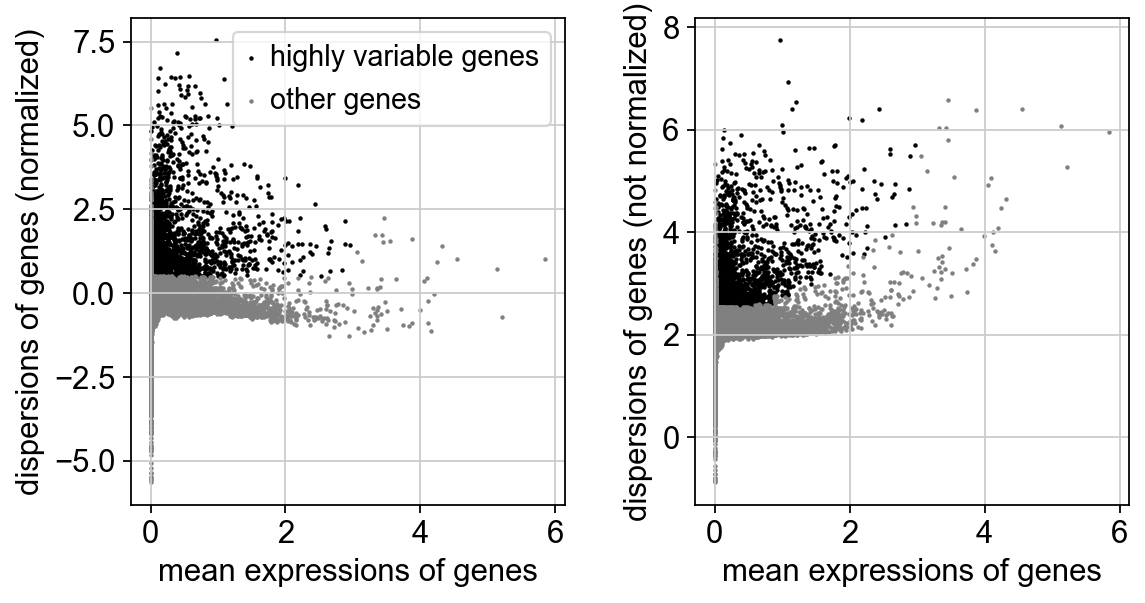

In [35]:
sc.pp.normalize_total(bdata, target_sum=1e4)
sc.pp.log1p(bdata)

sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(bdata)

In [36]:
np.sum(bdata.var["highly_variable"])

2544

In [37]:
sc.tl.pca(bdata, random_state=RANDOM_STATE)

### Look at various embeddings

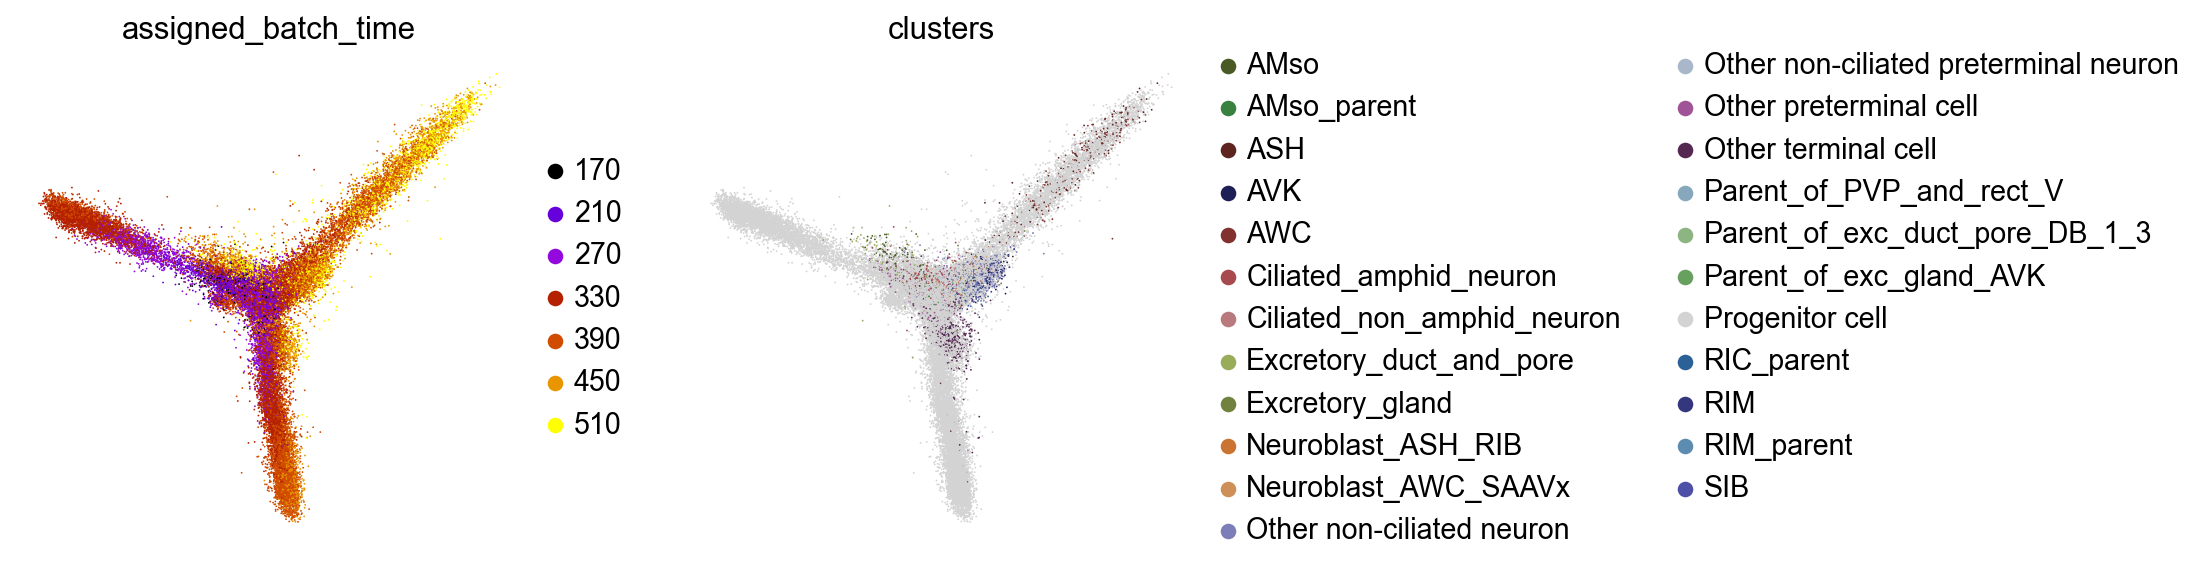

In [38]:
sc.pl.embedding(bdata, basis="pca", color=[TIME_KEY, "clusters"])

Compute neighbors and UMAP

In [39]:
sc.pp.neighbors(bdata, random_state=RANDOM_STATE)
sc.tl.umap(bdata, random_state=RANDOM_STATE)

Visualize the UMAP

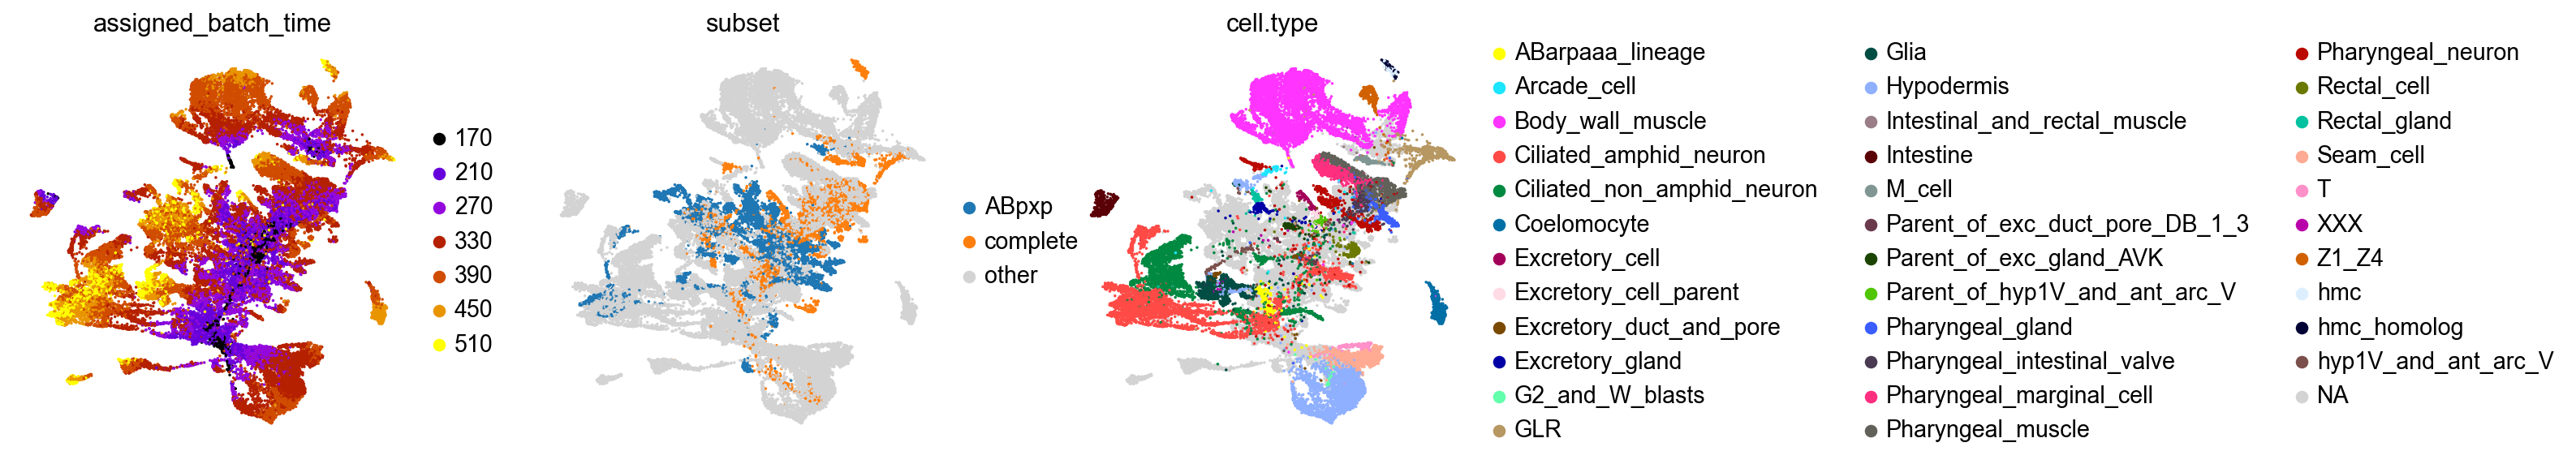

In [40]:
sc.pl.embedding(bdata, basis="umap", color=[TIME_KEY, "subset", "cell.type"], size=10)

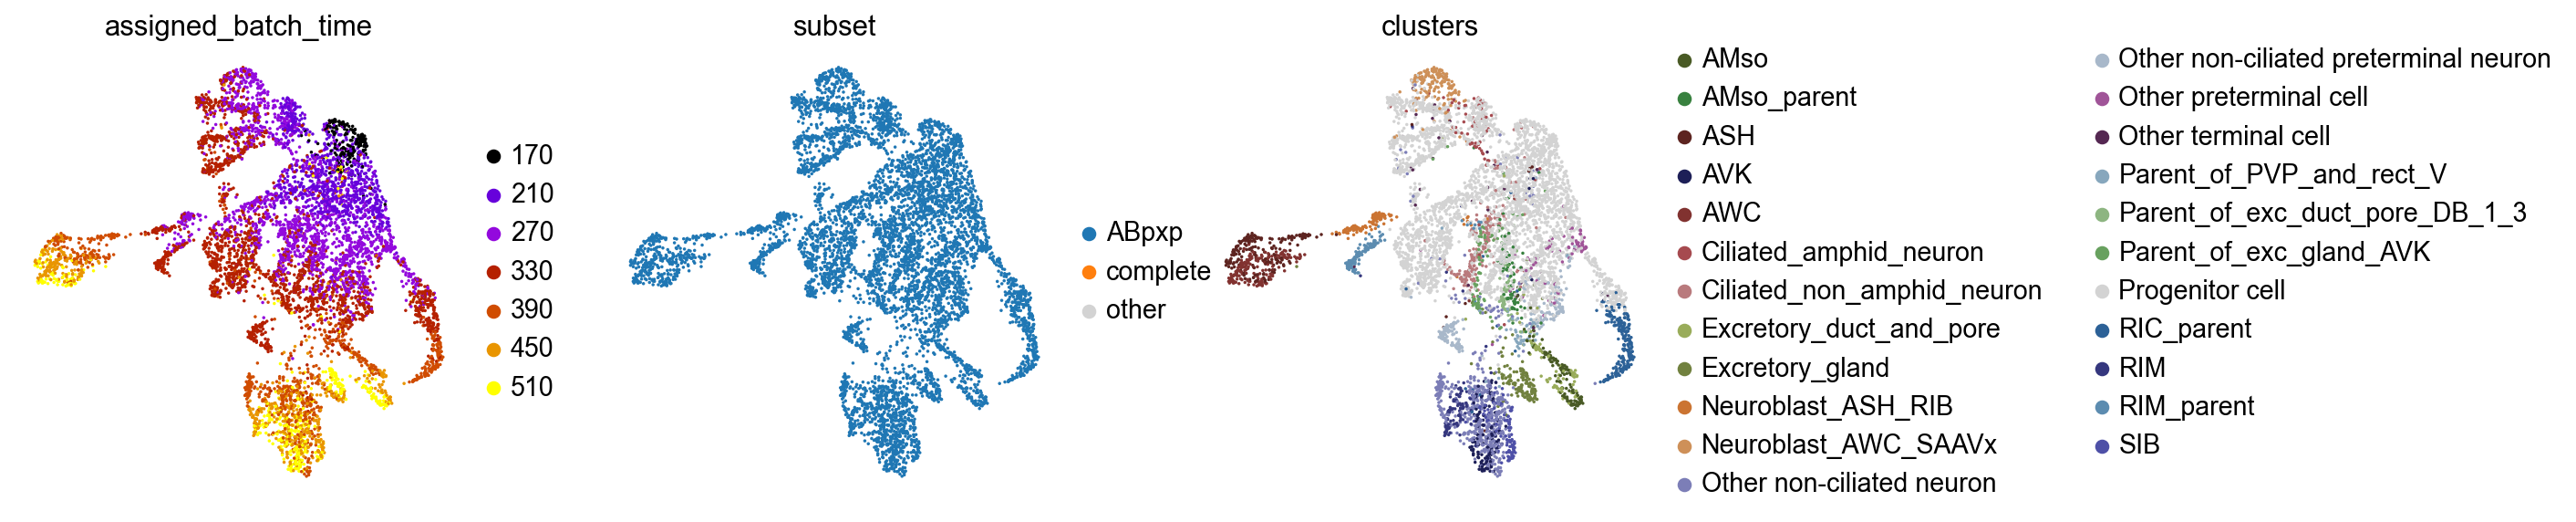

In [41]:
sc.pl.embedding(bdata, basis="umap_abpxp", color=[TIME_KEY, "subset", "clusters"], size=10)

Let's put the embedding back into AnnData

In [42]:
# Create a mask for cell in adata that exist in bdata
mask = adata.obs_names.isin(bdata.obs_names)

# Initialize UMAP and PCA fields in adata with Nan values
adata.obsm["X_umap"] = np.full((adata.n_obs, 2), fill_value=np.nan)
adata.obsm["X_pca"] = np.full((adata.n_obs, bdata.obsm["X_pca"].shape[1]), fill_value=np.nan)

# Sort bdata to match the order of cell in adata
bdata = bdata[bdata.obs_names.isin(adata.obs_names[mask])].copy()

# Use the mask to assign embedding coordinates from bdata to adata
adata.obsm["X_umap"][mask] = bdata.obsm["X_umap"].copy()
adata.obsm["X_pca"][mask] = bdata.obsm["X_pca"].copy()

Let's verify that this worked through plotting

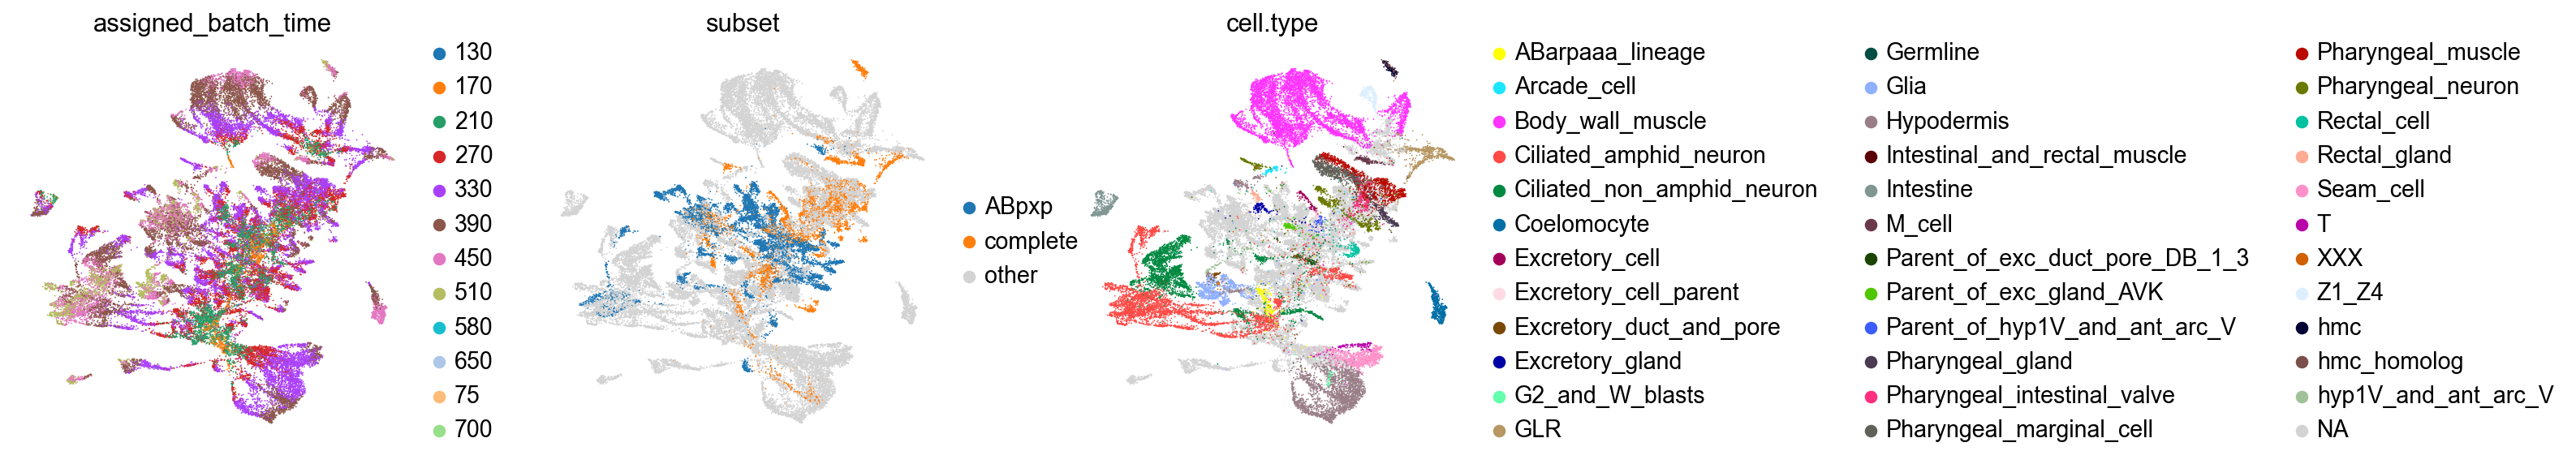

In [43]:
sc.pl.embedding(adata, basis="umap", color=[TIME_KEY, "subset", "cell.type"])

In [44]:
# adata.obsm['X_umap'] = bdata.obsm['X_umap'].copy()
# adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()

## Write to file

Write the AnnData. 

In [45]:
if write_data:
    adata.write(DATA_DIR / "ML_2024-06-09_c_elegans_prep.h5ad")